<a href="https://colab.research.google.com/github/mezkymy/global-salaries/blob/main/global-salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Salaries
source: https://ai-jobs.net/salaries/download/


## Data Description (from source)



> "We collect salary information anonymously from professionals and employers all over the world and make it publicly available for anyone to use, share and play around with.
> Our goal is to have open salary data for everyone. So newbies, experienced pros, hiring managers, recruiters and also startup founders or people wanting to switch careers can make better decisions."


In [1]:
# ignore FutureWarnings (for bioinfokit)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for tukey
!pip install bioinfokit
from bioinfokit.analys import stat

In [2]:
# load data
account = 'mezkymy'
repo = 'global-salaries'
branch = 'main'
data_file_name = 'salaries.csv'

url = str(f'https://raw.githubusercontent.com/{account}/{repo}/{branch}/{data_file_name}')

raw_data = pd.read_csv(url)
df = raw_data.copy()
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M


# Preliminary Data Exploration

In [3]:
# basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           8805 non-null   int64 
 1   experience_level    8805 non-null   object
 2   employment_type     8805 non-null   object
 3   job_title           8805 non-null   object
 4   salary              8805 non-null   int64 
 5   salary_currency     8805 non-null   object
 6   salary_in_usd       8805 non-null   int64 
 7   employee_residence  8805 non-null   object
 8   remote_ratio        8805 non-null   int64 
 9   company_location    8805 non-null   object
 10  company_size        8805 non-null   object
dtypes: int64(4), object(7)
memory usage: 756.8+ KB


In [4]:
# check values distribution on numerical data
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,8805.000000,8.805000e+03,8805.000000,8805.000000
mean,2022.737422,1.747287e+05,149488.265645,38.693924
std,0.542484,4.560690e+05,64222.105058,48.068060
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.055000e+05,105000.000000,0.000000
50%,2023.000000,1.441000e+05,142200.000000,0.000000
75%,2023.000000,1.900000e+05,185900.000000,100.000000
max,2023.000000,3.040000e+07,615201.000000,100.000000


## Remote Ratio

In [5]:
df.remote_ratio.unique()

array([  0, 100,  50])

Based on the data source and also by checking the data directly, we can see that `remote_ratio` only have three unique values: 0, 50, and 100. This data can be treated as categorical rather than numerical. 0 means up to 20% remote work, while 100 means more than 80% remote work. To avoid confusion with this numerical category, a new feature is created to categorize jobs as onsite, hybrid, and remote, based on its remote ratio.

In [6]:
cond = [df.remote_ratio < 50, df.remote_ratio > 50]
val = ['onsite', 'remote']

df['remote_cat'] = np.select(cond, val, 'hybrid')
pd.value_counts(df.remote_cat)

onsite    5289
remote    3298
hybrid     218
Name: remote_cat, dtype: int64

## Experience Level, Employment Type, and Company Size

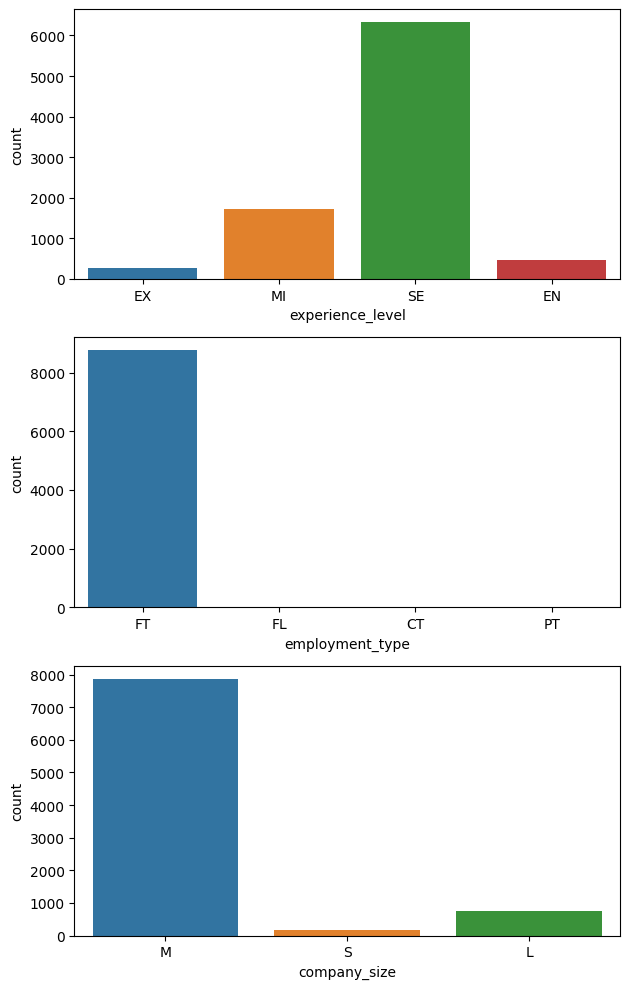

In [7]:
# show count plot based on experience level, employment type, and company size
columns = df.columns
cat = [columns[1], columns[2], columns[10]]
i = 0

fig, axes = plt.subplots(len(cat))

for col in cat:
    sns.countplot(df, ax=axes[i], x=col)
    i += 1

fig.set_figheight(10)
fig.tight_layout()
plt.show()

In [8]:
df.employment_type.value_counts()

FT    8762
CT      18
PT      13
FL      12
Name: employment_type, dtype: int64

Based on employment type, almost all jobs in this dataset are categorized as full-time (FT); while contract, part-time, and full-time jobs only occurs less than 20 times each. The overwhelming discrepancy and the lacking amount of data samples on the three minority categories should be considered when analyzing this dataset. To simplify analysis and also to avoid biases, **only full-time jobs will be analyzed further**.

Based on experience level and company size, there is one category on both variables that is significantly larger in their number of samples than the rest of categories, but other categories still have a decent amount of samples.

In [9]:
# filter dataset to only contain full time employees
df2 = df[df['employment_type'] == 'FT']

## Job Salaries

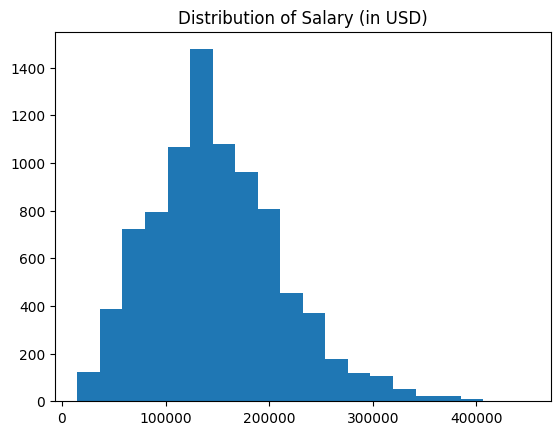

In [10]:
# salary distribution
plt.hist(df2.salary_in_usd, bins=20)

plt.title('Distribution of Salary (in USD)')
plt.show()

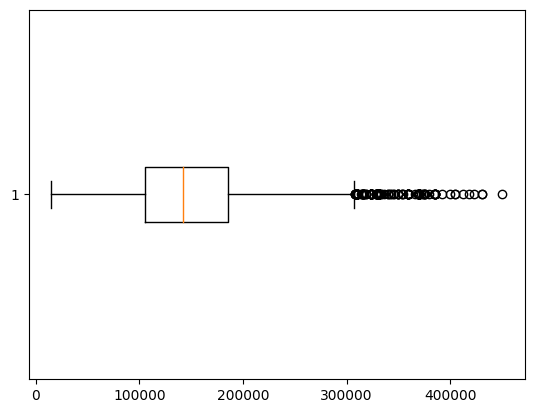

In [11]:
plt.boxplot(df2.salary_in_usd, vert=False)
plt.show()

Based on the distribution, most salaries in the dataset falls between 100K to 200K USD, while there are only a small amount of outliers with salaries above 300K. This is range of salaries combined from all job titles and experience levels. A more detailed analysis on salaries based on job titles and experience levels can be seen further down below.

## Job Titles

In [12]:
# count the number of unique job titles
print('Job Titles:', df2.job_title.unique())
print('\n Number of Unique Job Titles:', df2.job_title.nunique())

Job Titles: ['Data Science Director' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Specialist' 'Data Scientist'
 'ML Engineer' 'Data Engineer' 'Data Analyst' 'Data Architect'
 'Data Product Manager' 'Analytics Engineer' 'BI Data Analyst'
 'Research Scientist' 'Data Integration Engineer' 'AI Engineer'
 'Applied Scientist' 'Machine Learning Scientist' 'BI Developer'
 'Business Intelligence Manager' 'Data Integration Specialist'
 'Data Science Practitioner' 'Research Engineer'
 'Business Intelligence Analyst' 'Business Intelligence Developer'
 'AI Research Engineer' 'Data Science Consultant' 'Data Lead'
 'Head of Data' 'Data Management Specialist' 'AI Developer' 'Data Manager'
 'AI Architect' 'MLOps Engineer' 'Data Science Manager' 'Data Strategist'
 'Business Intelligence Specialist'
 'Machine Learning Infrastructure Engineer' 'Research Analyst'
 'Data Quality Engineer' 'Director of Data Science'
 'Business Data Analyst' 'Data Quality Analyst' 'AI Programmer'
 'Deci

We should take note that some job titles are actually similar, if not completely the same title, as another. For example, ML Engineer is basically the same as Machine Learning Engineer, while BI Analyst is also the same as Business Intelligence Analyst. To simplify things, we shall combine similar job titles as one.

In [13]:
df2.loc[df2.job_title=='BI Developer', 'job_title'] = 'Business Intelligence Developer'
df2.loc[df2.job_title=='BI Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='BI Data Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='BI Data Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='ML Engineer', 'job_title'] = 'Machine Learning Engineer'

In [14]:
# count the number of unique job titles after combining similar titles
print('Job Titles:', df2.job_title.unique())
print('\n Number of Unique Job Titles:', df2.job_title.nunique())

Job Titles: ['Data Science Director' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Specialist' 'Data Scientist'
 'Data Engineer' 'Data Analyst' 'Data Architect' 'Data Product Manager'
 'Analytics Engineer' 'Business Intelligence Analyst' 'Research Scientist'
 'Data Integration Engineer' 'AI Engineer' 'Applied Scientist'
 'Machine Learning Scientist' 'Business Intelligence Developer'
 'Business Intelligence Manager' 'Data Integration Specialist'
 'Data Science Practitioner' 'Research Engineer' 'AI Research Engineer'
 'Data Science Consultant' 'Data Lead' 'Head of Data'
 'Data Management Specialist' 'AI Developer' 'Data Manager' 'AI Architect'
 'MLOps Engineer' 'Data Science Manager' 'Data Strategist'
 'Business Intelligence Specialist'
 'Machine Learning Infrastructure Engineer' 'Research Analyst'
 'Data Quality Engineer' 'Director of Data Science'
 'Business Data Analyst' 'Data Quality Analyst' 'AI Programmer'
 'Decision Scientist' 'Financial Data Analyst' 'Data S

In [15]:
# list of job titles with more than 50 entries
job_title_count = df2.job_title.value_counts()
job_title_count[job_title_count.values > 50]

Data Engineer                      2059
Data Scientist                     1848
Data Analyst                       1317
Machine Learning Engineer          1001
Applied Scientist                   258
Research Scientist                  245
Analytics Engineer                  241
Data Architect                      199
Business Intelligence Engineer      134
Research Engineer                   133
Data Manager                        130
Data Science Manager                 92
Business Intelligence Analyst        88
Machine Learning Scientist           70
Business Intelligence Developer      67
Name: job_title, dtype: int64

In [16]:
# count of job titles with more than 50 entries
print('Number of unique job titles with more than 50 entries:', job_title_count[job_title_count.values > 50].count())

Number of unique job titles with more than 50 entries: 15


While there are many job titles in this dataset, some titles might be similar to the other in practice and only differing in its name. Many job titles have less than 50 entries, while only 15 titles occured more than 50 times in this dataset. The most common job titles are **Data Engineer**, **Data Scientist**, and **Data Analyst**.

In [17]:
# filtered dataframe containing only the titles that occurs more than 50 times
df3 = df2[df2['job_title'].isin(list(job_title_count[job_title_count.values > 50].index))]
df3

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M,onsite
5,2023,SE,FT,Machine Learning Engineer,132300,USD,132300,US,0,US,M,onsite
8,2023,SE,FT,Machine Learning Engineer,212000,USD,212000,US,0,US,M,onsite
...,...,...,...,...,...,...,...,...,...,...,...,...
8796,2021,MI,FT,Data Scientist,160000,SGD,119059,SG,100,IL,M,remote
8798,2021,MI,FT,Data Engineer,24000,EUR,28369,MT,50,MT,L,hybrid
8800,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,remote
8802,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S,remote


After filtering out jobs that occur less than 50 times in this dataset, we still retain 7882 data entries. Around one thousand entries has been removed compared to the original, but any analysis related to job title should now perform better.

## Company Locations

In [18]:
# count the number of unique company locations
print('Company Locations:', df3.company_location.unique())
print('\n Number of Unique Company Locations:', df3.company_location.nunique())

Company Locations: ['GB' 'US' 'CA' 'NL' 'LT' 'PT' 'AU' 'FR' 'CO' 'SI' 'ES' 'GR' 'UA' 'IN'
 'LV' 'DE' 'PL' 'EE' 'CZ' 'BR' 'IT' 'RU' 'KE' 'GH' 'SE' 'PH' 'TR' 'AD'
 'EC' 'MX' 'NO' 'AR' 'JP' 'NG' 'HK' 'CH' 'CF' 'IE' 'HR' 'AM' 'RO' 'TH'
 'HU' 'PR' 'FI' 'BE' 'ID' 'SG' 'EG' 'AE' 'MY' 'AT' 'CN' 'CL' 'LU' 'IL'
 'MT']

 Number of Unique Company Locations: 57


In [19]:
# list of company locations with more than 50 entries
company_location_count = df3.company_location.value_counts()
company_location_count[company_location_count.values > 50]

US    6931
GB     360
CA     174
ES      93
Name: company_location, dtype: int64

While there are 57 different countries where the data are sourced from, only 4 countries have more than 50 entries each. Since having less than 50 data may result in sampling bias, the analysis will focus only on the 4 countries.

In [20]:
# filtered dataframe containing only the titles that occurs more than 50 times
df4 = df3[df3['company_location'].isin(list(company_location_count[company_location_count.values > 50].index))]
df4

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M,onsite
5,2023,SE,FT,Machine Learning Engineer,132300,USD,132300,US,0,US,M,onsite
8,2023,SE,FT,Machine Learning Engineer,212000,USD,212000,US,0,US,M,onsite
...,...,...,...,...,...,...,...,...,...,...,...,...
8791,2020,MI,FT,Data Scientist,118000,USD,118000,US,100,US,M,remote
8792,2020,MI,FT,Data Scientist,138350,USD,138350,US,100,US,M,remote
8793,2020,MI,FT,Data Engineer,130800,USD,130800,ES,100,US,M,remote
8800,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,remote


# Remote Ratio to Salary

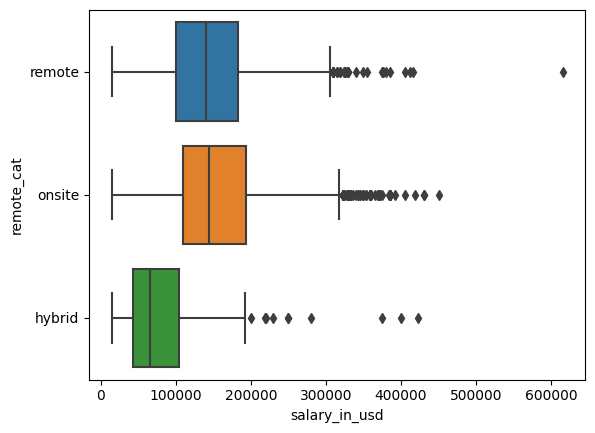

In [21]:
# order remote ratio by median value
group_remote = df4.loc[:,['remote_cat', 'salary_in_usd']] \
    .groupby(['remote_cat']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# boxplot for salary in usd based on experience level
sns.boxplot(data=df, x='salary_in_usd', y='remote_cat', order=group_remote.index)
plt.show()

While the salary between jobs with onsite or remote does not seem to differ significantly, hybrid jobs seems to earn significantly lower in general.

In [22]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ remote_cat', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
remote_cat,2.259809e+11,2.0,31.228121,3.115667e-14
Residual,2.733571e+13,7555.0,NaN,NaN


In [23]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='remote_cat', anova_model='salary_in_usd ~ remote_cat')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,onsite,remote,6839.831889,3469.236299,10210.427479,6.727341,0.001
1,onsite,hybrid,54378.199768,35080.354215,73676.045321,9.341586,0.001
2,remote,hybrid,47538.367879,28164.415717,66912.320041,8.134497,0.001


Tukey's HSD shows that all three categories differ with each other significantly, although the difference of salaries between onsite and remote jobs are not as large compared to the difference with hybrid jobs.

# Experience Levels per Job Title

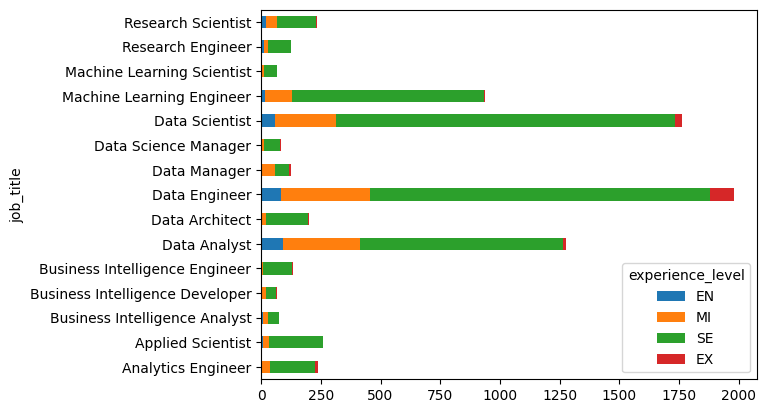

In [24]:
df4.groupby(by=['job_title', 'experience_level']).size().unstack().reindex(['EN','MI','SE','EX'], axis=1).plot(kind='barh', stacked=True)
plt.show()

In all selected job titles, most respondent are Senior-level, composing more than 50% of all experience level count. Mid-level are also quite common across the board, while entry level are mostly on Data Analyst, Engineer, or Scientist role.

# Salaries per Job Title & Experience Levels

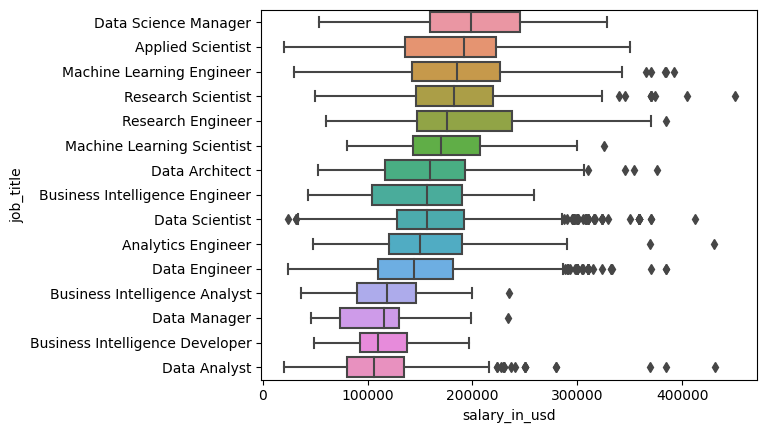

In [25]:
# order titles by median value
grouped = df4.loc[:,['job_title', 'salary_in_usd']] \
    .groupby(['job_title']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected job titles
sns.boxplot(data=df4, x='salary_in_usd', y='job_title', order=grouped.index)
plt.show()

In general, Data Analyst, BI Developer, BI Analyst, and Data Manager are the lowest paying job title among the selected job titles, with a significant portion of respondents on those groups having a salary less than 100k. Other job titles earning similar amounts to each other, typically ranging from 100k to 200k USD.

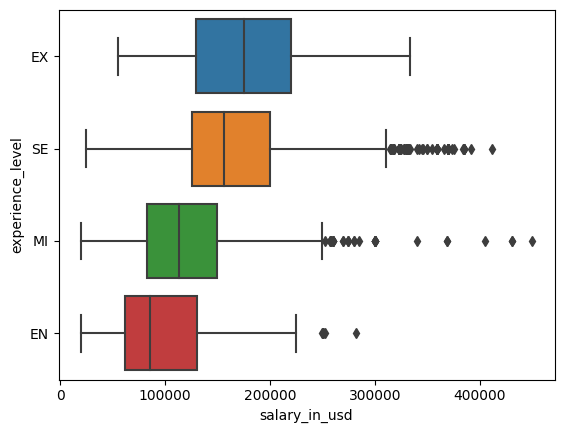

In [26]:
# order experience level by median value
grouped2 = df4.loc[:,['experience_level', 'salary_in_usd']] \
    .groupby(['experience_level']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# boxplot for salary in usd based on experience level
sns.boxplot(data=df4, x='salary_in_usd', y='experience_level', order=grouped2.index)
plt.show()

In [27]:
grouped2

,salary_in_usd
experience_level,
EX,175000.0
SE,156400.0
MI,113000.0
EN,85300.0


Based on experience level, the median value on lower experience level is less than the higher experience levels, but it is not quite clear-cut on whether the difference is significant or not based only on the graph above - especially since the highest salary among the dataset is earned by a mid-level, and that some executive-level still earns less than the average entry level, even when ignoring the outliers (which is shown by the dots on the graph above).

To check whether or not the difference of experience level is actually significant to salary earned, an analysis of variance (ANOVA) will be performed.

In [28]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ experience_level', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
experience_level,2.957932e+12,3.0,302.720891,1.362108e-185
Residual,2.460376e+13,7554.0,NaN,NaN


In [29]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='experience_level', anova_model='salary_in_usd ~ experience_level')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,MI,SE,42291.357939,37814.087463,46768.628414,34.325559,0.001000
1,MI,EX,56549.760938,44981.619583,68117.902294,17.764235,0.001000
2,MI,EN,21795.521760,12514.995936,31076.047584,8.534420,0.001000
3,SE,EX,14258.403000,3246.646471,25270.159528,4.705368,0.004886
4,SE,EN,64086.879698,55509.872820,72663.886577,27.152679,0.001000
5,EX,EN,78345.282698,64658.026198,92032.539198,20.800595,0.001000


Based on the p-value of ANOVA and the p-value of Tukey's HSD on all group pairs (lower than 0.01), we can conclude that each group of experience level is significantly different in their average salary received. The increase of salary goes in line with the increase in experience level, although some respondents with the lowest experience level (entry-level) still obtained a higher salary than the average salary of the highest experience level (executive-level).

Also, the difference of salary between Senior-level to Executive-level is around 14k, which is more or less 10% than the median value of

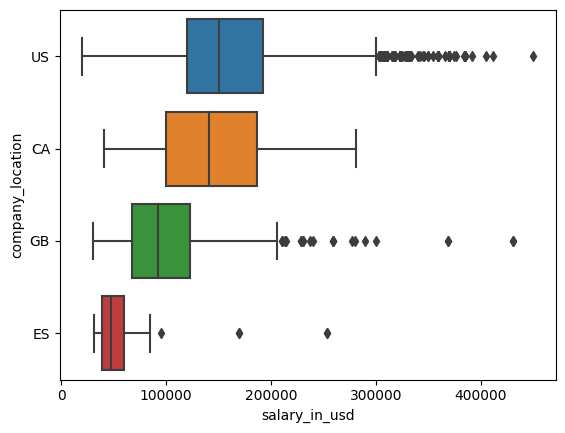

In [30]:
# order locations by median value
grouped3 = df4.loc[:,['company_location', 'salary_in_usd']] \
    .groupby(['company_location']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected company locations
sns.boxplot(data=df4, x='salary_in_usd', y='company_location', order=grouped3.index)
plt.show()

By analyzing the chart above visually, it can be predicted that company location might be more relevant than the actual job title and experience level. Spain (ES) only have 2 outliers that have a salary of more than 100k, while the majority of Great Britain (GB) earns around 100k. Most US and CA employees earns between 100k to 200k.

In [31]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ company_location', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
company_location,1.933282e+12,3.0,189.945665,9.358935e-119
Residual,2.562841e+13,7554.0,NaN,NaN


In [32]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='company_location', anova_model='salary_in_usd ~ company_location')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,GB,US,54505.199481,46414.594510,62595.804451,24.481401,0.001000
1,GB,CA,41384.473563,27565.321313,55203.625813,10.882667,0.001000
2,GB,ES,47309.916129,29900.146519,64719.685739,9.875031,0.001000
3,US,CA,13120.725917,1632.681258,24608.770576,4.150411,0.017621
4,US,ES,101815.115610,86191.214719,117439.016501,23.681113,0.001000
5,CA,ES,88694.389692,69468.954478,107919.824907,16.764835,0.001000


Based on both ANOVA and Tukey's HSD results, it can be assumed that company location significantly affects salary received, with every group/location differing to each other without exception.

# Salaries Based on Company Location & Job Titles

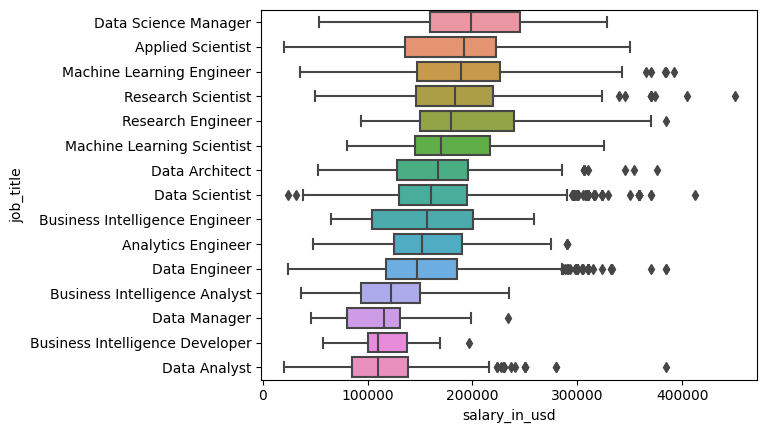

In [33]:
# order titles by median value
df_US = df4[df4['company_location'] == 'US']
grouped4 = df_US.loc[:,['job_title', 'salary_in_usd']] \
    .groupby(['job_title']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected job titles
sns.boxplot(data=df_US, x='salary_in_usd', y='job_title', order=grouped4.index)
plt.show()

# Yearly Salary Growth

In [34]:
grouped5 = df4.loc[:,['job_title', 'salary_in_usd', 'work_year']] \
    .groupby(['job_title', 'work_year']) \
    .mean() \

grouped5

salary_in_usd
job_title                       work_year               
Analytics Engineer              2022       143162.574074
                                2023       162257.846995
Applied Scientist               2022       188311.111111
                                2023       191289.025105
Business Intelligence Analyst   2020        98000.000000
                                2021        85314.750000
                                2022        66500.000000
                                2023       123853.521739
Business Intelligence Developer 2022       130000.000000
                                2023       113937.177419
Business Intelligence Engineer  2023       152842.373134
Data Analyst                    2020        82666.666667
                                2021        88887.000000
                                2022       110988.242308
                                2023       112257.630631
Data Architect                  2021       166666.666667
                                2022       166091.543478
                                2023       163799.866667
Data Engineer                   2020       121250.833333
                                2021       116487.888889
                                2022       142703.918455
                                2023       152893.313514
Data Manager                    2022       101839.428571
                                2023       111765.916667
Data Science Manager            2020       190200.000000
                                2021       153023.500000
                                2022       196465.821429
                                2023       215264.020000
Data Scientist                  2020       122827.200000
                                2021       100886.681818
                                2022       143638.245946
                                2023       167029.332597
Machine Learning Engineer       2020       179333.333333
                                2021       149047.000000
                                2022       160575.230769
                                2023       193584.393462
Machine Learning Scientist      2021       190000.000000
                                2022       155708.333333
                                2023       182772.346154
Research Engineer               2022       190736.000000
                                2023       189233.864407
Research Scientist              2020       450000.000000
                                2021        95978.600000
                                2022       184927.777778
                                2023       189966.811927

## Data Scientist

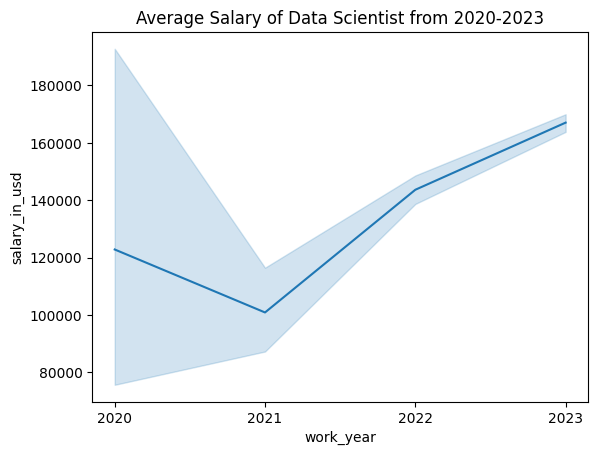

In [35]:
# Overall, using mean with 95% confidence interval
df_ds = df4[df4['job_title']=='Data Scientist']
sns.lineplot(data=df_ds, x="work_year", y="salary_in_usd")
plt.xticks(ticks=range(2020, 2024))
plt.title('Average Salary of Data Scientist from 2020-2023')
plt.show()

Data Scientist salaries across the board are increasing yearly, except at 2021 where it shows a decline from 122k to 100k. From 2020 to 2023, it shows a quite significant growth from 122k to 167k (+45k), which is a 36% increase over 3 years or 10% annual increase, significantly above the US inflation rate which lies around 1.4% to 7.0% during these period.

To further analyze this, we will check if the same increase happens on entry level-only too.

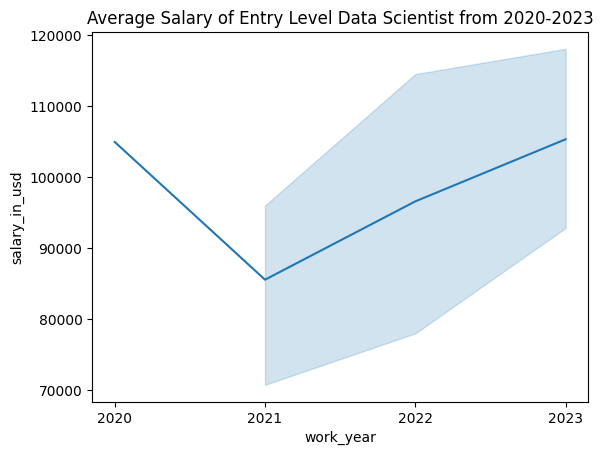

In [36]:
# Entry level-only
df_ds_en = df_ds[df_ds['experience_level']=='EN']
sns.lineplot(data=df_ds_en, x="work_year", y="salary_in_usd")
plt.xticks(ticks=range(2020, 2024))
plt.title('Average Salary of Entry Level Data Scientist from 2020-2023')
plt.show()

In [37]:
group_ds_en = df_ds_en.loc[:,['job_title', 'salary_in_usd', 'work_year']] \
    .groupby(['job_title', 'work_year']) \
    .mean() \

group_ds_en

salary_in_usd
job_title      work_year               
Data Scientist 2020       105000.000000
               2021        85600.000000
               2022        96631.277778
               2023       105377.914286

There are not enough data to show confidence interval on 2020, but from 2021 to 2023 the average salary of entry level Data Scientist shows an increase from 85k to 105k (+20k), which is a 23% increase over 2 years or 11% annual increase, similar to the overall average increase.

### Per Location Analysis

In [38]:
# group by job title, location, and year
grouped6 = df4.loc[:,['job_title', 'salary_in_usd', 'company_location', 'work_year']] \
    .groupby(['job_title', 'company_location', 'work_year']) \
    .median() \
    .reset_index()

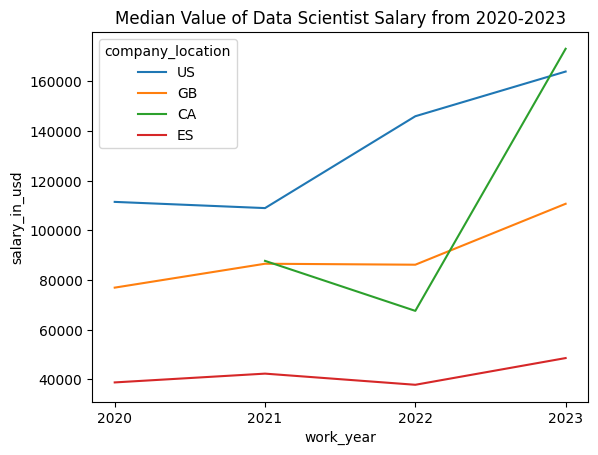

In [39]:
# Per location, using median
sns.lineplot(data=grouped6[grouped6['job_title']=='Data Scientist'], x="work_year", y="salary_in_usd", hue='company_location', hue_order = ['US', 'GB', 'CA', 'ES'])
plt.xticks(ticks=range(2020, 2024))
plt.title('Median Value of Data Scientist Salary from 2020-2023')
plt.show()

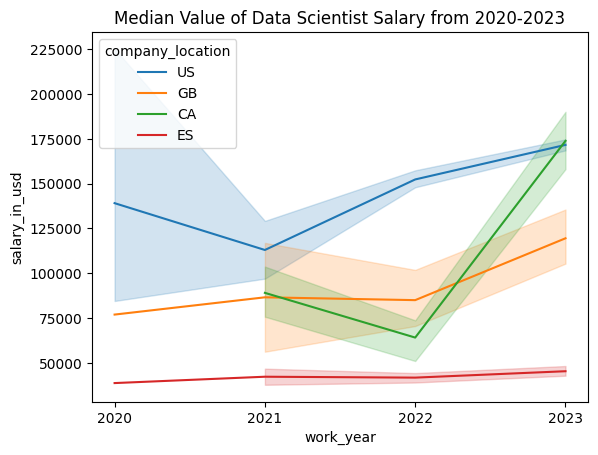

In [40]:
# using mean, with 95% confidence interval
sns.lineplot(data=df4[df4['job_title']=='Data Scientist'], x="work_year", y="salary_in_usd", hue='company_location', hue_order = ['US', 'GB', 'CA', 'ES'])
plt.xticks(ticks=range(2020, 2024))
plt.title('Median Value of Data Scientist Salary from 2020-2023')
plt.show()

In [41]:
# check data for Data Scientist on Great Britain, year 2020
df4[(df4['job_title']=='Data Scientist') & (df4['company_location']=='GB') & (df4['work_year']==2020)]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
8640,2020,MI,FT,Data Scientist,60000,GBP,76958,GB,100,GB,S,remote


In [42]:
# check data for Data Scientist on Spain, year 2020
df4[(df4['job_title']=='Data Scientist') & (df4['company_location']=='ES') & (df4['work_year']==2020)]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
8778,2020,MI,FT,Data Scientist,34000,EUR,38776,ES,100,ES,M,remote


There is only one entry each on Data Scientist role for Great Britain and Spain on year 2020, which means analysis on both countries might be not conclusive on said year. However, in all graphs and on all countries, the overall salary increases and reaches its highest average/median over 4 years at 2023.

## Data Scientist vs Data Analyst

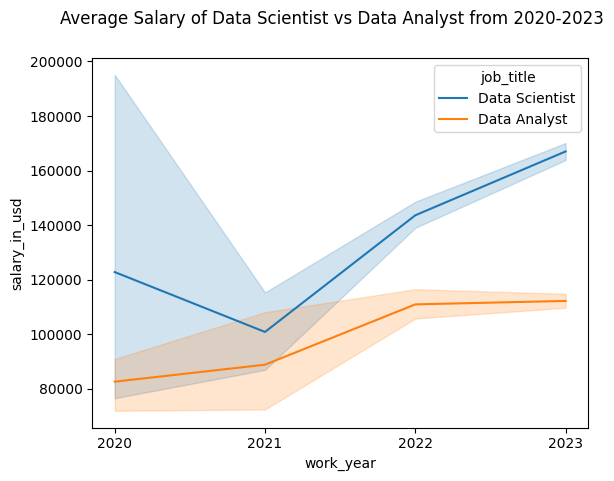

In [43]:
# Overall, using mean with 95% confidence interval
df_ds_da = df4[(df4['job_title']=='Data Scientist') | (df4['job_title']=='Data Analyst')]
sns.lineplot(data=df_ds_da, x="work_year", y="salary_in_usd", hue='job_title')
plt.xticks(ticks=range(2020, 2024))
plt.suptitle('Average Salary of Data Scientist vs Data Analyst from 2020-2023')
plt.show()

In [44]:
df_ds_da.loc[:,['job_title', 'salary_in_usd', 'company_location', 'work_year']] \
    .groupby(['job_title', 'work_year']) \
    .mean() \
    .reset_index()

,job_title,work_year,salary_in_usd
0,Data Analyst,2020,82666.666667
1,Data Analyst,2021,88887.000000
2,Data Analyst,2022,110988.242308
3,Data Analyst,2023,112257.630631
4,Data Scientist,2020,122827.200000
5,Data Scientist,2021,100886.681818
6,Data Scientist,2022,143638.245946
7,Data Scientist,2023,167029.332597


Data Scientists on average have a higher salary compared to Data Analysts, although the wage gap is quite small at year 2021. At 2020, Data Scientists earns around 49% more than Data Analysts, which is almost identical at year 2023. Both jobs also have a similar salary increase of 36% between 2020 to 2023.